# Inversion ( from uniform to a certain probability)

- Exponential 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
lambda_val = 2  # Rate parameter for Exponential(λ)

# Generate uniform random numbers
U = np.random.uniform(0, 1, 10000)

# Apply inverse transformation
X = -np.log( U) / lambda_val

# Plot histogram to compare with theoretical PDF
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")

# Plot theoretical density function
x_vals = np.linspace(0, 3, 1000)
pdf = lambda_val * np.exp(-lambda_val * x_vals)
plt.plot(x_vals, pdf, 'r', lw=2, label="Theoretical PDF")

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Exponential Distribution Sampling (λ=2)")
plt.legend()
plt.show()


- Bernouilli

In [7]:
#parameters
p=0.5
U = np.random.uniform(0, 1, 10000)
X = (U < p).astype(int)

unique, counts = np.unique(X, return_counts=True)
print(unique,counts)


[0 1] [4988 5012]


- Pareto

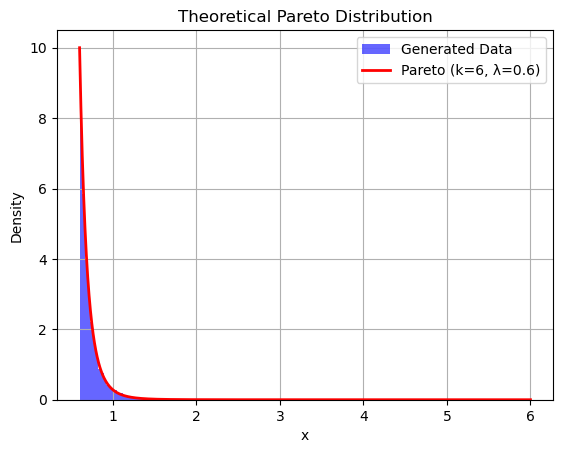

In [23]:
from scipy.stats import pareto
lmb=0.6
k=6
U = np.random.uniform(0, 1, 10000)
X = lmb/U**(1/k)

# Plot histogram to compare with theoretical PDF
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")

# Generate x values for the theoretical Pareto distribution
x_vals = np.linspace(lmb, lmb*10 , 1000)
pdf = pareto.pdf(x_vals, k, scale=lmb)

# Plot the theoretical Pareto distribution

plt.plot(x_vals, pdf, 'r-', lw=2, label=f'Pareto (k={k}, λ={lmb})')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Theoretical Pareto Distribution')
plt.legend()
plt.grid()
plt.show()

- Laplace

[-4.27403773 -0.18456041  0.         ...  0.          0.
 -0.56871064]


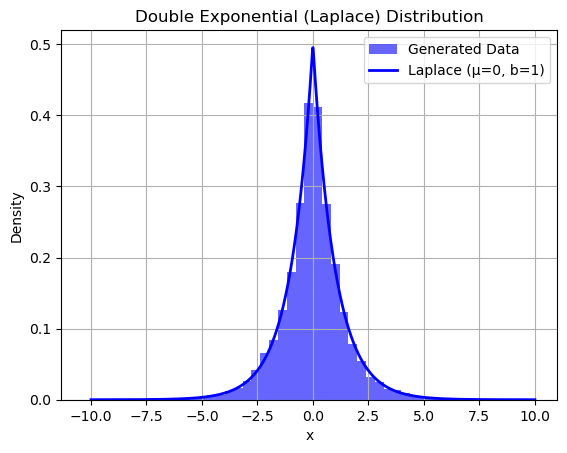

In [68]:
U = np.random.uniform(0, 1, 10000)

from scipy.stats import laplace
left=np.log(2*U)*(U <= 0.5).astype(int)
right=-np.log(-2*(U-1))*(U > 0.5).astype(int)
print(left)
for i,(el_x,el_y) in enumerate(zip(left,right)):
    if el_x==0:
        left[i]=right[i]
  
plt.hist(left, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")   

x = np.linspace(-10, 10, 1000)
pdf = laplace.pdf(x, loc=0, scale=1)


plt.plot(x, pdf, 'b-', lw=2, label=f'Laplace (μ={0}, b={1})')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Double Exponential (Laplace) Distribution')
plt.legend()
plt.grid()
plt.show()